In [1]:
import sys
from pathlib import Path

# Add project root to Python path
PROJECT_ROOT = Path(r"C:\Users\gayat\OneDrive\Desktop\audioshots-recommendation-ml\audioshots-recommendation-ml")
sys.path.append(str(PROJECT_ROOT))

import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt

# Import our recommendation function
from src.inference.recommend import recommend_for_user


In [2]:
AUDIO_DATA_PATH = PROJECT_ROOT / "data/processed/audio_language_category.csv"
ITEM_ENCODER_PATH = PROJECT_ROOT / "models_saved/item_encoder.pkl"
USER_ENCODER_PATH = PROJECT_ROOT / "models_saved/user_encoder.pkl"

In [3]:
def load_data():
    print("LOADING DATA...")
    print("="*70 + "\n")
    
    # Load audio metadata (has language and category for each audio)
    audio_df = pd.read_csv(AUDIO_DATA_PATH)
    print(f"Loaded {len(audio_df)} audio metadata records")
    
    # Load item encoder (converts audio_id to index and vice versa)
    with open(ITEM_ENCODER_PATH, "rb") as f:
        item_encoder = pickle.load(f)
    print(f"Loaded item encoder with {len(item_encoder.classes_)} items")
    
    # Load user encoder (to get list of users)
    with open(USER_ENCODER_PATH, "rb") as f:
        user_encoder = pickle.load(f)
    print(f"Loaded user encoder with {len(user_encoder.classes_)} users\n")
    
    return audio_df, item_encoder, user_encoder


In [4]:
def get_recommendations_with_metadata(user_id, audio_df, top_k=10):
    print(f"Getting recommendations for user: {user_id}")
    
    # Get recommended audio IDs from the model
    recommended_audio_ids = recommend_for_user(user_id, top_k=top_k)
    print(f"Got {len(recommended_audio_ids)} recommendations\n")
    
    # Create a list to store results
    results = []
    
    # For each recommended audio, find its language and category
    for audio_id in recommended_audio_ids:
        # Find this audio in the metadata
        audio_info = audio_df[audio_df['audio_id'] == audio_id]
        
        if not audio_info.empty:
            # Get the first row (in case audio has multiple categories)
            info = audio_info.iloc[0]
            results.append({
                'audio_id': audio_id,
                'language': info['language'],
                'category': info['category']
            })
        else:
            # If not found, mark as unknown
            results.append({
                'audio_id': audio_id,
                'language': 'Unknown',
                'category': 'Unknown'
            })
    
    return pd.DataFrame(results)

In [5]:
def visualize_recommendations(recommendations_df, user_id):
    print("CREATING VISUALIZATION")
    print("="*70 + "\n")
    
    # Count languages and categories
    language_counts = Counter(recommendations_df['language'])
    category_counts = Counter(recommendations_df['category'])
    
    # Create figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'Recommendation Analysis for User: {user_id}', 
                 fontsize=16, fontweight='bold')
    
    # === LEFT PLOT: Language Distribution ===
    languages = list(language_counts.keys())
    lang_values = list(language_counts.values())
    colors1 = plt.cm.Set3(range(len(languages)))
    
    ax1.bar(languages, lang_values, color=colors1, edgecolor='black')
    ax1.set_xlabel('Language', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Number of Recommendations', fontsize=12, fontweight='bold')
    ax1.set_title('Distribution by Language', fontsize=14)
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(lang_values):
        ax1.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')
    
    # === RIGHT PLOT: Category Distribution ===
    categories = list(category_counts.keys())
    cat_values = list(category_counts.values())
    colors2 = plt.cm.Pastel1(range(len(categories)))
    
    ax2.bar(categories, cat_values, color=colors2, edgecolor='black')
    ax2.set_xlabel('Category', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Recommendations', fontsize=12, fontweight='bold')
    ax2.set_title('Distribution by Category', fontsize=14)
    ax2.grid(axis='y', alpha=0.3)
    
    # Rotate category labels if too many
    if len(categories) > 3:
        ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for i, v in enumerate(cat_values):
        ax2.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
      
    # Show the plot
    plt.show()

In [6]:
def print_detailed_table(recommendations_df):
    print("DETAILED RECOMMENDATIONS")
    print("="*70 + "\n")
    
    print(f"{'No.':<5} {'Audio ID':<30} {'Language':<15} {'Category':<20}")
    print("-"*70)
    
    for idx, row in recommendations_df.iterrows():
        print(f"{idx+1:<5} {row['audio_id']:<30} {row['language']:<15} {row['category']:<20}")

In [7]:
audio_df, item_encoder, user_encoder = load_data()

# Show preview of audio data
print("\nPreview of audio metadata:")
display(audio_df.head())

LOADING DATA...

Loaded 23884 audio metadata records
Loaded item encoder with 10140 items
Loaded user encoder with 53 users


Preview of audio metadata:


,audio_id,title,language,category
0,67893e6513537f4d2049d451,5 Financial Rules Buying a House ｜ Business ｜ ...,English,Business
1,67893e6513537f4d2049d451,5 Financial Rules Buying a House ｜ Business ｜ ...,English,Educational
2,67893e6613537f4d2049d468,Alcohol Causes Cancer ｜ Business ｜ Sarthak Ahuja,English,Business
3,67893e6613537f4d2049d468,Alcohol Causes Cancer ｜ Business ｜ Sarthak Ahuja,English,Educational
4,67893e6813537f4d2049d47f,Are Publishers Cashing in on Book Piracy？ ｜ Bu...,English,Business


In [8]:
available_users = user_encoder.classes_
print("AVAILABLE USERS")
print("="*70 + "\n")
print(f"Total users in system: {len(available_users)}")
print(f"\nFirst 10 user IDs:")
for i, user_id in enumerate(available_users[:10], 1):
    print(f"  {i}. {user_id}")

AVAILABLE USERS

Total users in system: 53

First 10 user IDs:
  1. 6787a5aeb6de5685cf6da19b
  2. 678e867b9fe1d22e8f6a44f2
  3. 678f77499fe1d22e8f6a5179
  4. 67909870e65df45dd604beda
  5. 6792356ae65df45dd604eba7
  6. 67939d19e65df45dd604f9d2
  7. 6793b285e65df45dd604ffca
  8. 67966b9912bc2f462318d3c8
  9. 6797916e041017eca3de3041
  10. 679900889cd5a42618255dd2


In [9]:
user_id = available_users[3] 
recommendations_df = get_recommendations_with_metadata(user_id, audio_df, top_k=10)
print_detailed_table(recommendations_df)


Getting recommendations for user: 67909870e65df45dd604beda
Got 10 recommendations

DETAILED RECOMMENDATIONS

No.   Audio ID                       Language        Category            
----------------------------------------------------------------------
1     678bf605f5489fb0e0250ce6       English         Finance             
2     678e1c48f39856f152353942       English         Productivity        
3     679cffc705a1d9b38bbdc956       English         Business            
4     678e3212f39856f152359a09       English         Productivity        
5     678d452866775883717f574a       English         Finance             
6     678d42a366775883717f2ddf       English         Finance             
7     678bf681f5489fb0e025164c       English         Finance             
8     6899ce87d10bebd21f6aea72       Unknown         Unknown             
9     678bf5d3f5489fb0e025098b       English         Finance             
10    678d406e66775883717f09d2       English         Finance             


In [10]:
print("SUMMARY STATISTICS")
print(f"Total recommendations: {len(recommendations_df)}")
print(f"Unique languages: {recommendations_df['language'].nunique()}")
print(f"Unique categories: {recommendations_df['category'].nunique()}")

print("\nLanguage breakdown:")
for lang, count in recommendations_df['language'].value_counts().items():
    print(f"  • {lang}: {count}")

print("\nCategory breakdown:")
for cat, count in recommendations_df['category'].value_counts().items():
    print(f"  • {cat}: {count}")



SUMMARY STATISTICS
Total recommendations: 10
Unique languages: 2
Unique categories: 4

Language breakdown:
  • English: 9
  • Unknown: 1

Category breakdown:
  • Finance: 6
  • Productivity: 2
  • Business: 1
  • Unknown: 1


CREATING VISUALIZATION



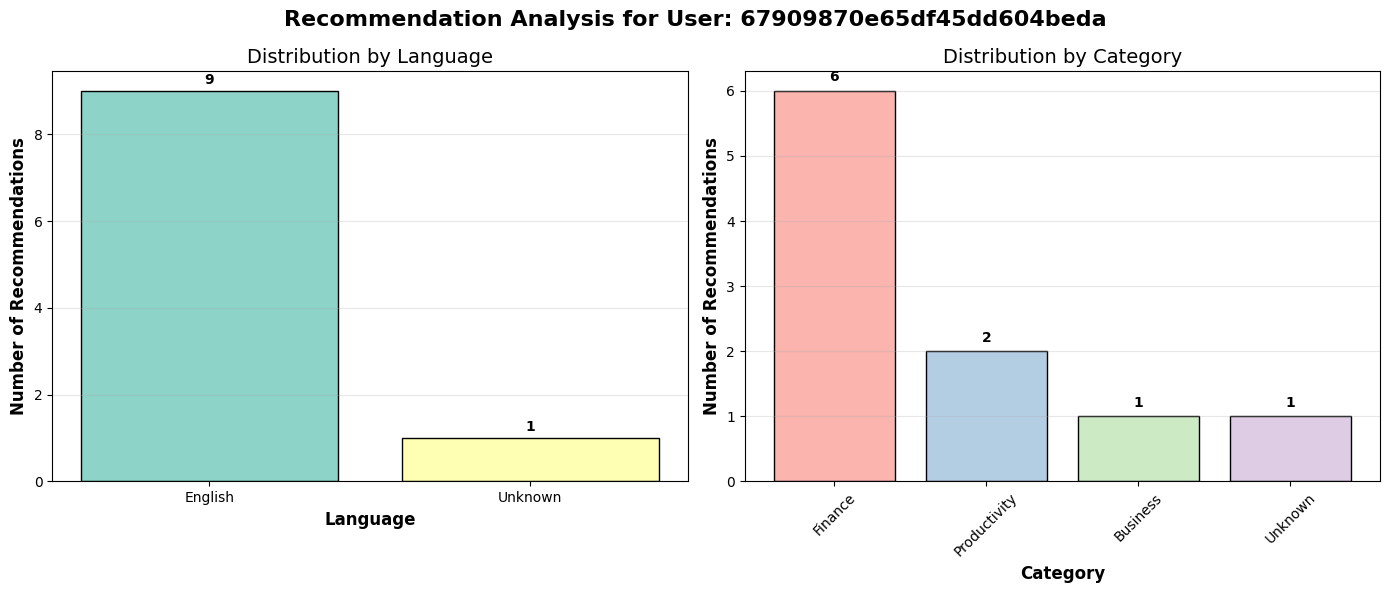

In [11]:
visualize_recommendations(recommendations_df, user_id)


Getting recommendations for user: 678e867b9fe1d22e8f6a44f2
Got 10 recommendations

DETAILED RECOMMENDATIONS

No.   Audio ID                       Language        Category            
----------------------------------------------------------------------
1     678bf605f5489fb0e0250ce6       English         Finance             
2     678e1c48f39856f152353942       English         Productivity        
3     678e3212f39856f152359a09       English         Productivity        
4     678d43e866775883717f4216       English         Finance             
5     678e187ef39856f152351d74       English         Productivity        
6     678d41f966775883717f23a1       English         Finance             
7     678d42a366775883717f2ddf       English         Finance             
8     679cffc705a1d9b38bbdc956       English         Business            
9     678bf7ecf5489fb0e0253028       English         Finance             
10    678bf6cdf5489fb0e0251b7e       English         Finance             
CREATI

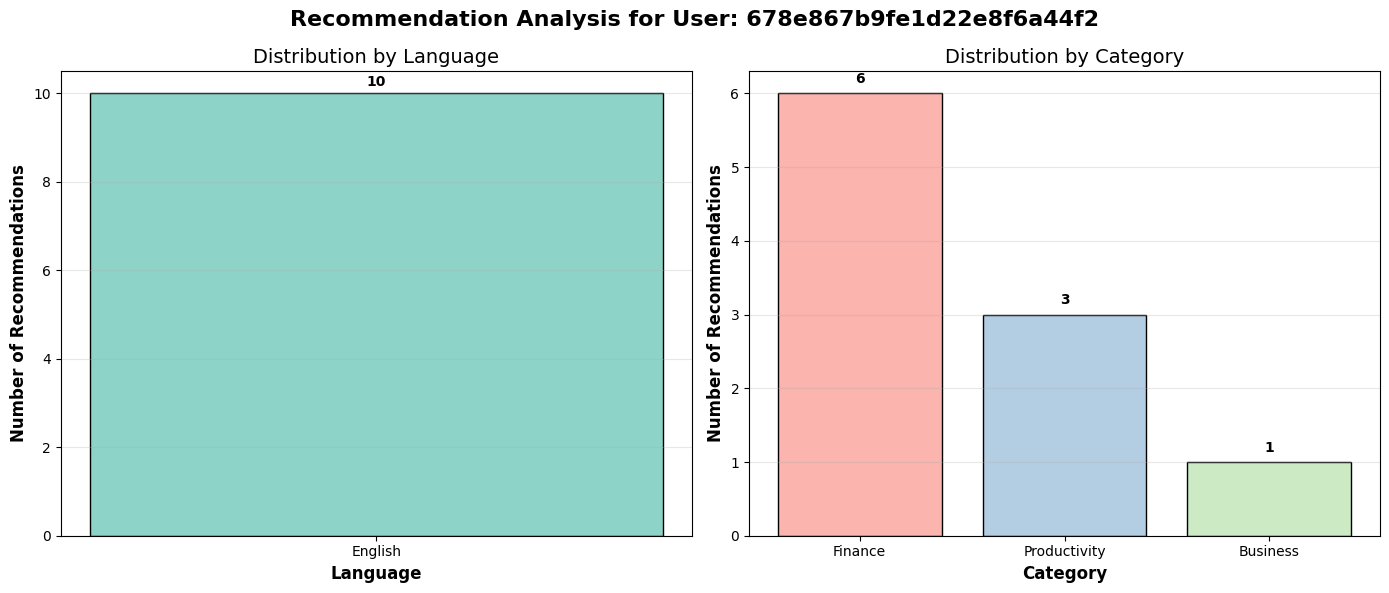

In [12]:
another_user_id = available_users[1]  # Try second user
# Get recommendations
recommendations_df2 = get_recommendations_with_metadata(another_user_id, audio_df, top_k=10)

# Print table
print_detailed_table(recommendations_df2)

# Create visualization
visualize_recommendations(recommendations_df2, another_user_id)

COMPARING MULTIPLE USERS

Getting recommendations for user: 6787a5aeb6de5685cf6da19b
Got 10 recommendations

Getting recommendations for user: 678e867b9fe1d22e8f6a44f2
Got 10 recommendations

Getting recommendations for user: 678f77499fe1d22e8f6a5179
Got 10 recommendations



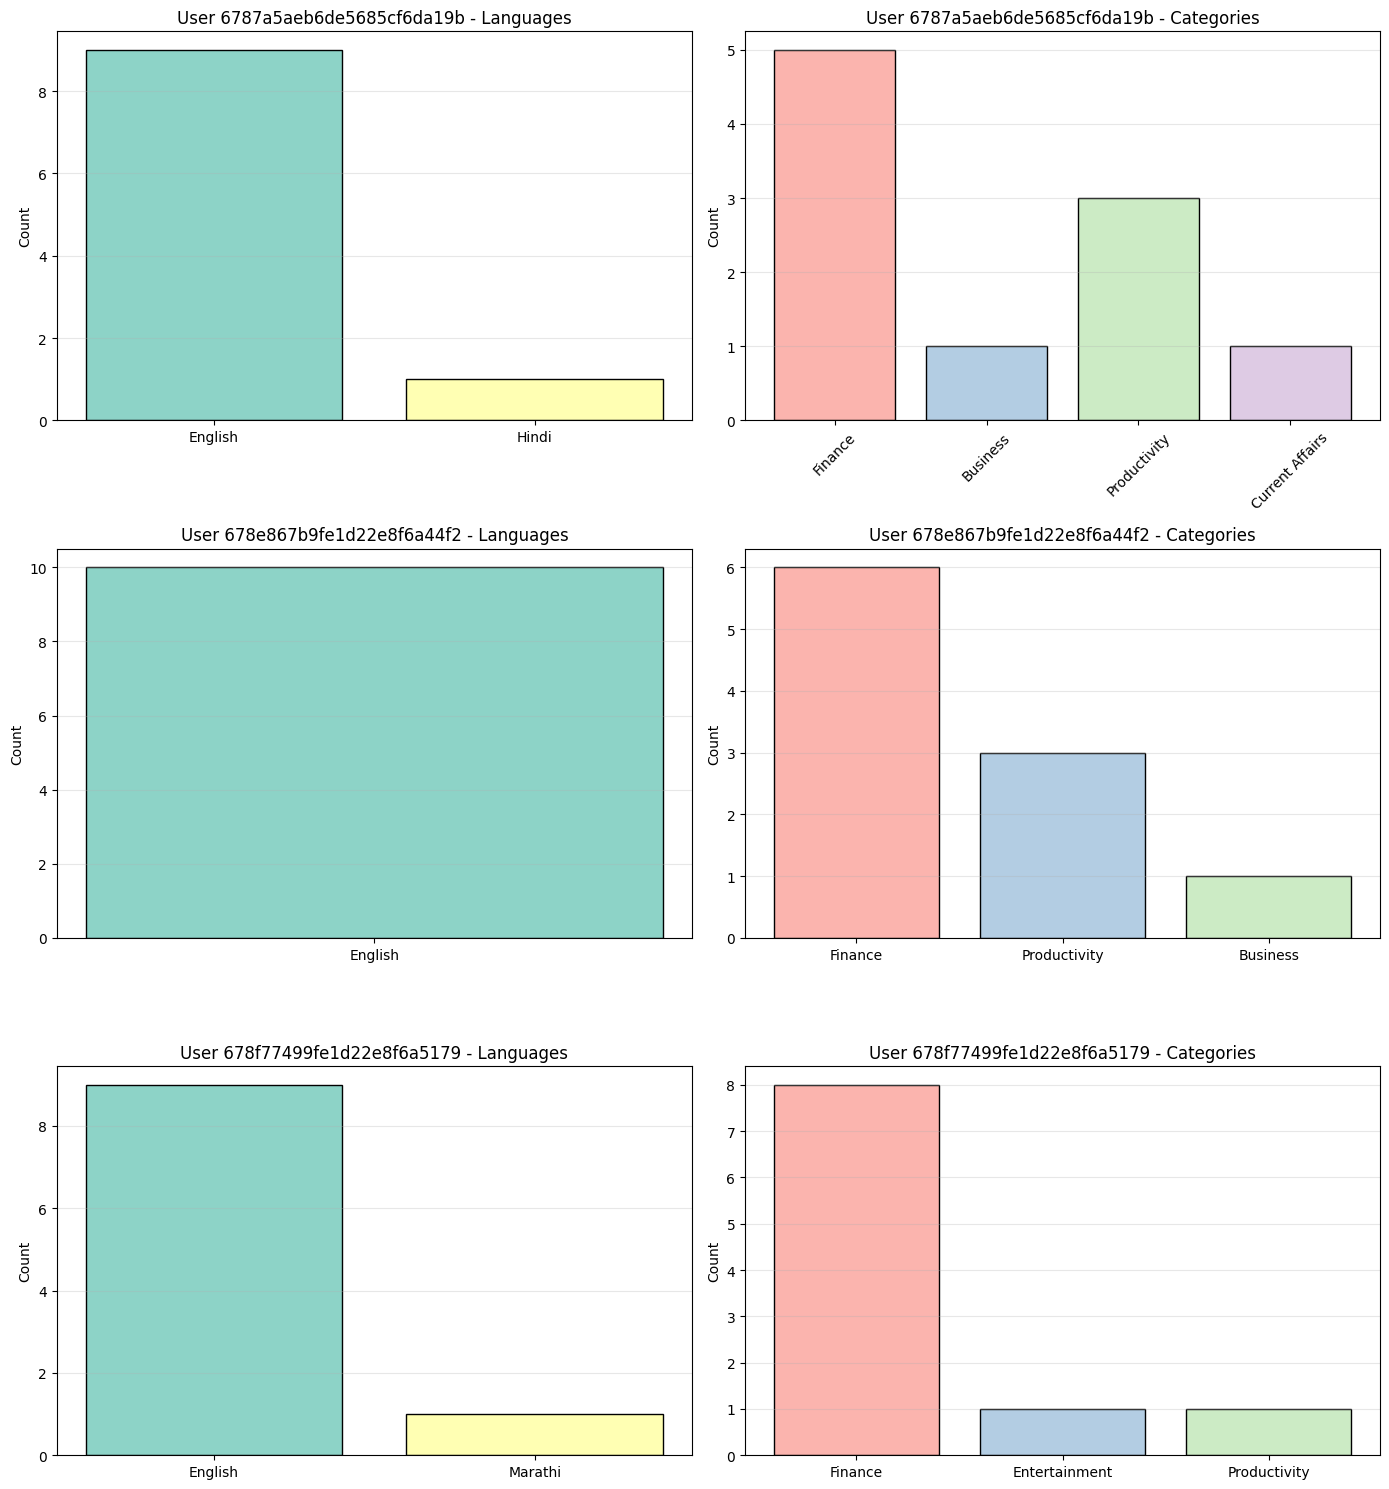

In [13]:
print("COMPARING MULTIPLE USERS")
print("="*70 + "\n")

# Select 3 users to compare
users_to_compare = available_users[:3]

fig, axes = plt.subplots(len(users_to_compare), 2, figsize=(14, 5*len(users_to_compare)))

for idx, uid in enumerate(users_to_compare):
    # Get recommendations
    rec_df = get_recommendations_with_metadata(uid, audio_df, top_k=10)
    
    # Count distributions
    lang_counts = Counter(rec_df['language'])
    cat_counts = Counter(rec_df['category'])
    
    # Language plot
    ax1 = axes[idx, 0] if len(users_to_compare) > 1 else axes[0]
    languages = list(lang_counts.keys())
    lang_values = list(lang_counts.values())
    ax1.bar(languages, lang_values, color=plt.cm.Set3(range(len(languages))), edgecolor='black')
    ax1.set_title(f'User {uid} - Languages')
    ax1.set_ylabel('Count')
    ax1.grid(axis='y', alpha=0.3)
    
    # Category plot
    ax2 = axes[idx, 1] if len(users_to_compare) > 1 else axes[1]
    categories = list(cat_counts.keys())
    cat_values = list(cat_counts.values())
    ax2.bar(categories, cat_values, color=plt.cm.Pastel1(range(len(categories))), edgecolor='black')
    ax2.set_title(f'User {uid} - Categories')
    ax2.set_ylabel('Count')
    if len(categories) > 3:
        ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
